<h4 align='right'> $\textit{Aurélien Castre, Eliott Tourtois}$ </h4>
<h1 align='center'> $\textbf{Filtrage - MACS207b}$ </h1>
$\newline$

# Ce qu'il reste à faire :

- tweak kmeans
- comparer les deux méthodes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import signal
from sklearn.cluster import KMeans

$\textbf{Question 1}$

$\tau$ suit une loi exponentielle de paramètre $\mu$, on peut donc facilement calculer $h$ :

$$ h(s)=\frac{f(s)}{1-F(s)}= \left\{
    \begin{array}{ll}
        \frac{\mu\exp(-\mu s)}{\exp(-\mu s)} & \mbox{si } s \in \mathbb{R}_+ \\
        0 & \mbox{sinon.}
    \end{array}
\right. = \mu \mathbb{1}_{\mathbb{R}_+}(s) $$

$\textbf{Question 2}$

Pour simuler $N$ sur l'intervalle de temps $[0, T]$, on commence par tirer $\tau$ selon une loi exponentielle de paramètre $\mu$. Ensuite, on tire les instants de saut de $N_a$ selon une loi exponentielle de paramètre $a$ en partant de 0 et tant qu'on ne dépasse pas la valeur de $\tau(\omega)$. Enfin, on tire les instants de saut de $N_b$ selon une loi exponentielle de paramètre $b$ en partant de $\tau(\omega)$ et tant qu'on ne dépasse pas $T$.

In [3]:
def N(a, b, mu = 0.2, end = 10, rng = np.random.default_rng(None)) :
    """Simulate the trajectory of N between 0 and T

    Parameters
    ----------
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    mu : float, optional
        The parameter of the exponential distribution of tau
    end : float, optional
        The end of the simulation
    rng : Generator, optional
        A Random Number Generator for reproducibility
        (default is np.random.default_rng(None))

    Returns
    -------
    float
        The value of tau in the simulation
    list
        The list of arrival times of the Poisson process before tau
    list
        The list of arrival times of the Poisson process after tau
        (empty if tau > T)
    """
    
    # Simulate tau using inverse transform sampling
    u = rng.uniform()
    tau = -1/mu*np.log(u)
    
    # Simulate the first Poisson process
    Tas = []
    t = 0
    while t <= min(tau, end) :
        u = rng.uniform()
        t += -1/a*np.log(u)
        Tas.append(t)
    Tas.pop()
    
    # Simulate the second Poisson process
    Tbs = []
    t = tau
    while t <= end :
        u = rng.uniform()
        t += -1/b*np.log(u)
        Tbs.append(t)
    # Pop the last arrival time (which might be greater that T) only
    # if Tbs is not empty (which is the case when tau > T)
    if Tbs:
        Tbs.pop()
        
    return tau, Tas, Tbs

In [4]:
def plotN(tau, Tas, Tbs, end = 10, z_estimate = None, kmeans_estimate = None) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float, optional
        The end of the simulation
    z_estimate : float, optional
        Plots the estimated value of tau using Z
        (defaults is None)
    kmeans_estimate : tuple, optional
        Plots the estimated interval of tau using kmeans
        (defaults is None)
    """
    
    T = Tas + Tbs
    plt.figure(figsize = (16,6))
    plt.step([0] + T + [end], [0] + [i for i in range(len(T) + 1)], label=r'$N(t)$')
    
    if tau <= end:
        plt.vlines(tau, 0, len(T) + 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=r'$\tau \approx $' + str(tau)[:4])
    
    if kmeans_estimate :
        plt.fill_betweenx(np.linspace(0,len(T) + 1), kmeans_estimate[0], kmeans_estimate[1], alpha = 0.2,\
                          color = 'g', label = "kmeans estimate")
    if z_estimate :
        plt.vlines(z_estimate, 0, len(T) + 1, color='g', label=r'$\hat{\tau} \approx $' + str(z_estimate)[:4])
    
    plt.legend(loc = 'right', fontsize = 18)
    plt.xticks(range(end + 1))
    plt.grid()

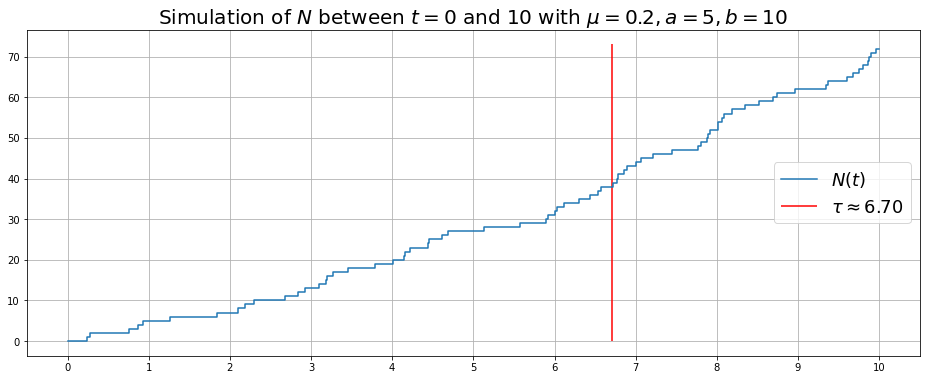

In [151]:
seed = 2
# 5 c'est très mauvais pour kmeans, 3 tau est loin, 4 tau est au tout début, 2 Z est pas ouf
rng = np.random.default_rng(seed)

mu = 0.2
a = 5
b = 10
end = 10

tau, Tas, Tbs = N(mu, a, b, end, rng)
plotN(tau, Tas, Tbs, end)
plt.title(rf"Simulation of $N$ between $t = 0$ and {end} with $\mu = {mu}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

$\textbf{Question 3}$

Pour calculer $\hat Z$, on utilise le résultat de la question 10 de l'exercice 2.2 du polycopié, *i.e.*
$$\hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t \left(h(s) - (b-a)\hat{Z}(s)\right)\left(1-\hat{Z}(s)\right)\mathrm{d}s$$

On remarque qu'en dehors des instants de sauts, $\hat Z$ est $\mathcal{C}^1$. On peut donc dériver l'équation ci-dessus pour obtenir l'équation différentielle ci-dessous que nous résoudrons numériquement entre chaque instant de saut :
$$\frac{\mathrm{d}}{\mathrm{d}t}\hat{Z}(t) = \left(\mu - (b-a)\hat{Z}(t)\right)\left(1-\hat{Z}(t)\right)$$

Quant à la valeur aux instants de sauts, elle est donnée par la formule
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a)\hat{Z}(T_n^-)\left(1-\hat{Z}(T_n^-)\right)}{a + (b-a)\hat{Z}(T_n^-)}$$

Pour approximer $\hat{Z}(T_n^-)$, on choisira simplement le dernier point de la simulation numérique qui précède le saut.

Dans la suite du code, `Z` désignera $\hat Z$.

In [5]:
def Z(mu, a, b, end, T, num = 50) :
    """Computes an approximation of the conditional expectation Z(t) for
    all t between 0 and T

    Parameters
    ----------
    mu : float
        The parameter of the exponential distribution of tau
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    end : float
        The end of the simulation
    T : list
        The arrival times of N
    num : int, optional
        The number of points used to approximate Z between any two arrival times
        (default is 50)

    Returns
    -------
    list
        The list of points used to plot Z (linspaces + arrival times)
    numpy array
        1D array of values of Z
    """

    dZ = lambda y, t : (mu - (b - a)*y)*(1 - y)
    z = [0]
    ts = []
    jumps = []
    for i in range(len(T) - 1):
        t = np.linspace(T[i], T[i+1], num)[:-1]
        ts += list(t)
        # Solve the differential equation between two points
        z = np.append(z, odeint(dZ, z[-1], t).flatten())
        zjump = (b-a)*z[-1]*(1 - z[-1])/(a + (b-a)*z[-1])
        # Add the jump
        z = np.append(z, zjump + z[-1])
        jumps.append(zjump + z[-1])
        ts.append(T[i+1])

    return ts, z[1:], jumps

In [6]:
def plotZ(ts, z, tau, end) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float
        The end of the simulation
    """
    
    plt.figure(figsize = (16,6))
    plt.plot(ts, z, label=r'$\hatZ (t) = \mathbb{E}\left[\mathbb{1}_{\tau \leq t}|\mathcal{F}^N_t\right]$')
    plt.xticks(range(end + 1))
    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    plt.legend(fontsize = 15)
    plt.grid()

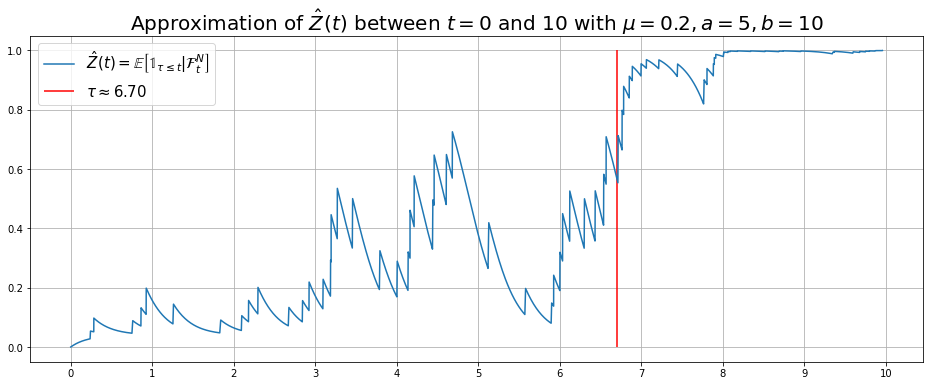

In [152]:
T = [0] + Tas + Tbs
ts, z, jumps = Z(mu, a, b, end, T)

plotZ(ts, z, tau, end)
plt.title(rf"Approximation of $\hatZ (t)$ between $t = 0$ and {end} with $\mu = {mu}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

Il faut ensuite calculer l'approximation de $\tau$. Pour cela, nous proposons une méthode en deux temps.
- Il faut d'abord lisser la courbe de $\hat{Z}$ pour ignorer les sauts ainsi que les erreurs qui peuvent être commises du fait du caractère aléatoire des données (par malchance, on peut avoir beaucoup de sauts rapprochés avant $\tau$, ce qui conduirait à une augmentation abrupte de $\hat{Z}$). L'objecif est de se rapprocher de l'allure d'une sigmoïde ou d'une indicatrice.
- Ensuite, il faut choisir l'abscisse qui approximera le mieux $\tau$. Nous proposons encore deux méthodes :
    - fixer un seuil (par exemple 0.5) est mesurer le premier dépassement de ce seuil par la courbe lissée,
    - dériver la coubre lissée et choisir l'abscisse du maximum.
    
Dans la suite de la réponse, on définira une méthode d'évalutation pour ensuite choisir la meilleure technique d'approximation.

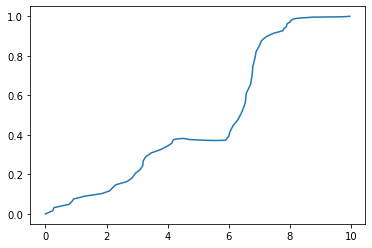

In [8]:
window = signal.hamming(800)
zfiltered = signal.filtfilt(window, 1, z)
plt.plot(ts,zfiltered/np.max(zfiltered))

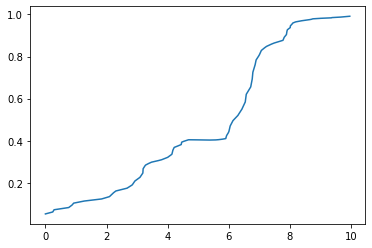

In [9]:
d, c = signal.butter(1, 0.001)
zsmo = signal.filtfilt(d, c, z)
plt.plot(ts, zsmo)

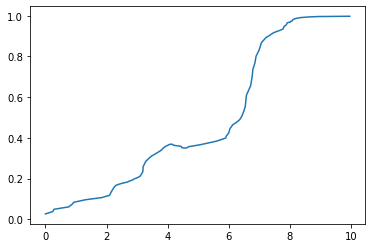

In [10]:
plt.plot(ts, signal.savgol_filter(z, 801, 1))

In [11]:
def treshold_estimate(ts, zfiltered, tresh) :
    times = []
    for i in range(len(zfiltered)) :
        if ((zfiltered[i] > tresh) and (zfiltered[i-1] <= tresh)):
            times.append(ts[i])
    if len(times) > 1:
        return (times[-1] + times[-2])/2
    else :
        return(times[0])

In [12]:
def zfilter(z, name) :
    if name == 'hamming' :
        window = signal.hamming(800)
        zfiltered = signal.filtfilt(window, 1, z)
        return zfiltered/np.max(zfiltered)
    if name == 'butterworth' :
        d, c = signal.butter(1, 0.001)
        return signal.filtfilt(d, c, z)
    if name == 'savgol' :
        return signal.savgol_filter(z, 801, 1)
    else :
        print("Wrong filter name.")

In [126]:
# Fonction pour tester la qualité des résultats

def evaluate_treshold(n, mu, a, b, zfilter_name = 'butterworth', tresh = 0.4, end = 2/mu, rng = np.random.default_rng(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(mu, a, b, 2*end, rng = rng)
        ts, z, jumps = Z(mu, a, b, 2*end, [0] + Tas + Tbs, num = 50) #on simule jusqu'à 2*end pour être sûrs de choper le moment où ça explose
        zfiltered = zfilter(z, zfilter_name)
        htau = treshold_estimate(ts, zfiltered, tresh)
        error += np.abs(htau - tau)
    return error/n

In [125]:
# Fonction pour tester la qualité des résultats

def evaluate_gradient(zfilter_name, n, mu, a, b, tresh = 0.5, end = 2/mu, rng = np.random.default_rng(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(mu, a, b, 2*end, rng = rng)
        ts, z, jumps = Z(mu, a, b, 2*end, [0] + Tas + Tbs, num = 50) #on simule jusqu'à 2*end pour être sûrs de choper le moment où ça explose
        zfiltered = zfilter(z, zfilter_name)
        htau = ts[np.argmax(np.gradient(zfiltered))]
        error += np.abs(htau - tau)
    return error/n

In [15]:
%%timeit
print(evaluate_treshold('butterworth', 10, 0.2, 5, 10))

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
%%timeit
print(evaluate_treshold('hamming', 10, 0.2, 5, 10))

In [ ]:
%%timeit
print(evaluate_treshold('savgol', 10, 0.2, 5, 10))

conclusion de cette partie : butterworth est le plus rapide

In [ ]:
rng = np.random.default_rng(42)
evaluate_gradient('savgol', 1000, 0.2, 5, 10, rng = rng)

In [ ]:
rng = np.random.default_rng(42)
evaluate_treshold('hamming', 1000, 0.2, 5, 10, rng = rng)

In [ ]:
tresholds = np.arange(0.2, .8, 0.1)
errors = []
for tresh in tresholds :
    errors.append(evaluate_treshold('savgol', 50, 0.2, 5, 10, tresh = tresh))
plt.plot(tresholds, errors)

In [ ]:
rng = np.random.default_rng(42)
evaluate_treshold('butterworth', 1000, 0.2, 5, 10, rng = rng, tresh = 0.4)

$\textbf{Question 4}$

Pour approximer $\tau$ en utilise l'algorithme kmeans, on va d'abord appliquer une méthode naïve. On fait tourner l'algorithme sur la liste des instants de saut pour les séparer en 2 clusters. Ensuite, on approxime tau par la moyenne des deux instants de saut qui se situent à la frontière. On utilisera kmeans++ pour initialiser notre algorithme (ainsi, on s'assure que les deux premiers instants soient suffisamment éloignés pour espérer qu'ils tombent dans $N_a$ et dans $N_b$) et on répète l'algorithme 10 fois (`n_init = 10`).

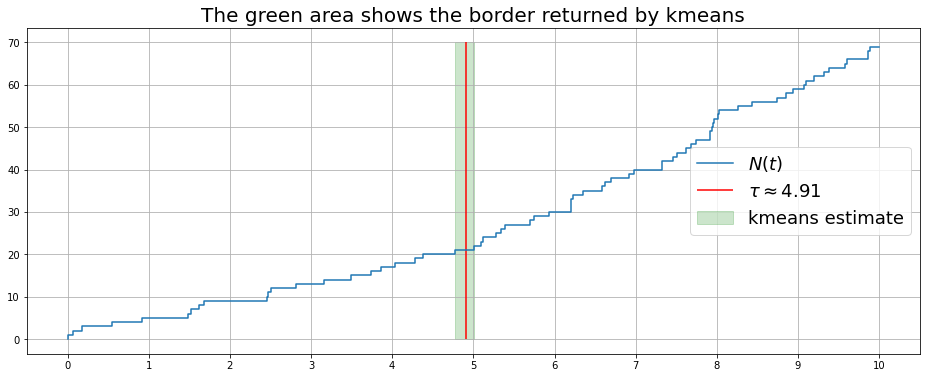

In [63]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

# Generate N again with a RandomState generator this time (required for kmeans implementation in scipy)
tau, Tas, Tbs = N(a, b, rng=rng)
T = [0] + Tas + Tbs

points = np.array(T).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
pred = kmeans.predict(points)
p = abs((1-pred[0])-pred) # make sure 1's are before 0's
plotN(tau, Tas, Tbs, kmeans_estimate = (T[p.sum()-1], T[p.sum()]))
plt.title("The green area shows the border returned by kmeans", fontsize = 20)
plt.show()

Le graphe ci-dessus suggère que cette méthode naïve pourrait s'avérer assez efficace. Evaluons maintenant ses performances de façon plus rigoureuse.

In [22]:
def evaluate_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [51]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_kmeans(100, a, b, rng = rng)

2.8733964466881816

Les résultats sont en fait moins bon que ce que suggérait l'exemple, nous avons donc essayé de changer l'initialisation de l'algorithme en prenant en compte la valeur de $\mu$. En effet, celle-ci est utilisée dans l'approximation donnée par $\hat{Z}$, il est donc naturel de s'en autoriser la connaissance ici aussi.

In [26]:
def evaluate_kmeans_mu_init(n, a, b, mu = 0.2, rng = np.random.RandomState(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        
        T = [0] + Tas + Tbs
        m = np.mean(T)
        def mu_init(X, n_clusters, random_state) :
            X = X.flatten() + m
            i = len([x for x in X if x < 1/mu])
            return [X[random_state.randint(i, len(X))]-m], [X[random_state.randint(0, i)]-m]
        
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=10, init=mu_init, random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [27]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_kmeans_mu_init(1000, a, b, rng = rng)

2.8496733896162443

La différence est minime et la méthode déterministe consistant à prendre le premier et le dernier élément des données comme pour initialiser l'algorithme s'avère non seulement plus rapide mais aussi équivalente en précision, comme le démontrent les cellules qui suivent.

In [29]:
def evaluate_deter_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        
        def deter_init(X, n_clusters, random_state) :
            return [X[0]], [X[-1]]
        
        points = np.array(T).reshape(-1, 1)
        kmeans = KMeans(n_clusters=2, n_init=1, init=deter_init, random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [53]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_kmeans_mu_init(1000, a, b, rng = rng)

2.8496733896162443

Pour essayer d'améliorer l'algorithme, une autre idée nous est venue à l'esprit. Celle-ci provient de la remarque que kmeans en une dimension n'est pas un algorithme très efficace : il risque de quasiment toujours couper au milieu. On pourrait donc essayer de trouver des fonctions des instants de sauts qui changent à $\tau$ et les ajouter à la valeur des instants de sauts pour créer des points en plusieurs dimensions.

Si on se donne un processus de poisson stationnaire alors il est possible d'approximer :
- son intensité en calculant $\frac{N(t)}{t}$ quand $t$ devient grand,
- l'inverse de son intensité en calculant la moyenne des temps d'inter-arrivées.

On va exploiter ces deux approximations pour créer un ensemble de points en trois dimensions.

In [58]:
rate_approx = []
for i in range(1, len(T)) :
    rate_approx.append(i/T[i])
rate_approx = np.array(rate_approx)
rate_approx

array([98.92825983, 27.58432609, 17.13133112,  7.31697905,  5.44507749,
        4.03378992,  4.61690164,  4.94449154,  5.33490186,  4.05902258,
        4.45387817,  4.78767477,  4.61590347,  4.43417938,  4.28999885,
        4.28438615,  4.40020671,  4.46500967,  4.44124962,  4.57004146,
        4.40226207,  4.39060835,  4.51936898,  4.69355872,  4.73978771,
        4.86799729,  5.00615544,  4.91202451,  5.04336405,  5.06156716,
        4.99977781,  5.15669734,  5.31484885,  5.45721018,  5.51253963,
        5.46964946,  5.58936003,  5.67013227,  5.64225843,  5.72868123,
        5.60154205,  5.7307225 ,  5.76091156,  5.86254987,  5.90409042,
        5.98396241,  6.06639656,  6.06334962,  6.18725532,  6.29328428,
        6.41411162,  6.53075128,  6.61362154,  6.73157374,  6.65506503,
        6.64502693,  6.52400811,  6.55422646,  6.59678374,  6.61216241,
        6.70847738,  6.74202986,  6.7574765 ,  6.82002671,  6.78491148,
        6.87348148,  6.79392704,  6.89440613,  6.97751045])

Si l'on ignore les 3 premières valeurs on voit que l'approximation est plutôt bonne : l'intensité empirique tend assez vite vers 5 puis, un peu après le dépassement de $\tau$ elle se remet à croître. Cela devrait donc accentuer la séparation des points autour de $\tau$.

In [59]:
interarrival_approx = []
parsum = 0
for i in range(1, len(T)) :
    parsum += T[i] - T[i - 1]
    interarrival_approx.append(parsum/i)
interarrival_approx = np.array(interarrival_approx)
interarrival_approx

array([0.01010834, 0.03625247, 0.05837258, 0.13666842, 0.18365212,
       0.24790582, 0.21659547, 0.20224526, 0.18744487, 0.24636473,
       0.22452343, 0.20886966, 0.21664231, 0.22552087, 0.2331003 ,
       0.23340567, 0.22726205, 0.22396368, 0.22516185, 0.2188164 ,
       0.22715595, 0.22775887, 0.22126983, 0.21305795, 0.21097991,
       0.20542329, 0.19975408, 0.20358205, 0.19828035, 0.19756727,
       0.20000889, 0.19392257, 0.18815211, 0.18324381, 0.18140459,
       0.18282707, 0.17891136, 0.17636273, 0.17723399, 0.17456025,
       0.17852227, 0.17449807, 0.17358364, 0.17057424, 0.1693741 ,
       0.16711335, 0.1648425 , 0.16492534, 0.16162255, 0.15889954,
       0.15590624, 0.15312174, 0.15120309, 0.14855367, 0.15026149,
       0.15048848, 0.15328001, 0.15257331, 0.15158902, 0.15123645,
       0.14906512, 0.14832328, 0.14798424, 0.14662699, 0.14738586,
       0.14548668, 0.14719028, 0.14504513, 0.14331759])

Ici encore, le résultat est plutôt prometteur : on tend relativement vite vers 0.2 puis on continue de diminuer après $\tau$. Codons maintenant une fonction permettant de facilement générer les points en 3D en fonction des instants de saut.

In [60]:
def points_3D(T) :
    rate_approx = []
    interarrival_approx = []
    parsum = 0
    for i in range(1, len(T)) :
        parsum += T[i] - T[i - 1]
        interarrival_approx.append(parsum/i)
        rate_approx.append(i/T[i])
    T = np.array(T[1:])
    interarrival_approx = np.array(interarrival_approx)
    rate_approx = np.array(interarrival_approx)
    return np.column_stack((T, interarrival_approx, rate_approx))

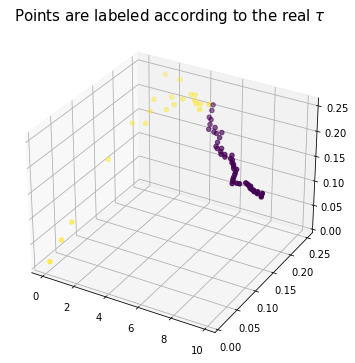

In [70]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# Computing the real labels of the points
labels = []
for i in range(1, len(T)) :
    if T[i] < tau :
        labels.append(1)
    else :
        labels.append(0)

points = points_3D(T)
ax.scatter(points.T[0], points.T[1], points.T[2], c=labels)
plt.title(rf"Points are labeled according to the real $\tau$", fontsize = 15)
plt.show()

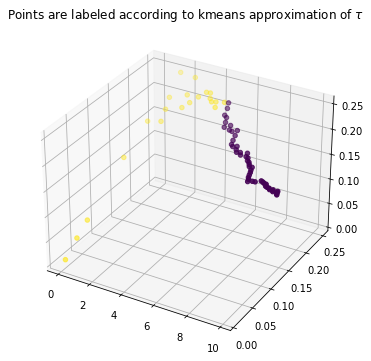

In [73]:
seed = 42
rng = np.random.RandomState(seed)

kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state = rng).fit(points)
pred = kmeans.predict(points)
p = abs((1-pred[0])-pred)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(points.T[0], points.T[1], points.T[2], c=p)
plt.title(rf"Points are labeled according to kmeans approximation of $\tau$", fontsize = 12)
plt.show()

Ici encore, la technique semble tout à fait prometteuse : la classification des points est bien réalisée par kmeans. Mettons la à l'épreuve d'une évaluation plus rigoureuse.

In [74]:
def evaluate_3D_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = points_3D(T)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred) 
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [86]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_3D_kmeans(1000, a, b, rng = rng)

2.768916272423207

Le résultat est une fois de plus très déçevant et le gain minime ! Nous avons alors essayé une dernière idée : ajouter deux dimensions de plus correspondant aux dérivées discrètes des approximations introduites plus tôt tout en enlevant les premières valeurs qui faussent la classification. L'idée derrière les dérivées est la même qu'à la question précédente : il s'agit d'accentuer la cassure qui se passe dans le voisinage de $\tau$.

In [90]:
def points_5D(T, a, burn_in = 2) :
    rate_approx = []
    interarrival_approx = []
    parsum = 0
    for i in range(1, len(T)) :
        parsum += T[i] - T[i - 1]
        interarrival_approx.append(parsum/i)
        rate_approx.append(i/T[i])
    T = np.array(T[1:])
    interarrival_approx = np.array(interarrival_approx)
    rate_approx = np.array(interarrival_approx)
    
    # Avoiding the first values
    for i in range(burn_in) :
        interarrival_approx[i] = np.mean(interarrival_approx[2:2*a])
        rate_approx[i] = np.mean(rate_approx[2:2*a])
    
    # Computing the discrete derivatives
    dinterarrival_approx = np.insert(interarrival_approx[1:] - np.roll(interarrival_approx, 1)[1:], 0, interarrival_approx[0])
    drate_approx = np.insert(rate_approx[1:] - np.roll(rate_approx, 1)[1:], 0, rate_approx[0])
    
    return np.column_stack((T, rate_approx, interarrival_approx, drate_approx, dinterarrival_approx))

In [92]:
def evaluate_5D_kmeans(n, a, b, rng = np.random.RandomState(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(a, b, rng = rng)
        T = [0] + Tas + Tbs
        points = points_5D(T, a)
        kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=rng).fit(points)
        pred = kmeans.predict(points)
        p = abs((1-pred[0])-pred)
        htau = (T[p.sum()-1] + T[p.sum()])/2
        error += np.abs(htau - tau)
    return error/n

In [93]:
seed = 42
rng = np.random.RandomState(seed)
a = 5
b = 10

evaluate_5D_kmeans(1000, a, b, rng = rng)

2.768916272423207

Cette fois il semble que le résultat ait été le même qu'en 3D sur 1000 échantillons différents, on peut donc conclure une fois de plus que cette technique n'apporte pas d'amélioration.

En conclusion, le meilleur compromis entre rapidité d'exécution, simplicité et précision semble être la version déterministe de kmeans en une dimension. C'est celle que nous utiliserons pour la comparaison dans la question suivante.

$\textbf{Question 5}$
- Pour k means il choisit un des sauts qui lui apparaissent bons mais aléatoirement
- k means n'utilise pas les données d'entrée (a,b,$\mu$)
- Pour l'autre méthode, on peut regarder la stabilité qui suit et donc choisir le seul truc stable